We will be trying to predict if a customer will be renting a film this month based on their previous activity and other details. We will first construct a table with:

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [3]:
result = engine.execute('SELECT * FROM film')
for row in result:
    print(row)
rows = [row for row in result]
pd.DataFrame(rows)

(1, 'ACADEMY DINOSAUR', 'A Epic Drama of a Feminist And a Mad Scientist who must Battle a Teacher in The Canadian Rockies', 2006, 1, None, 6, Decimal('0.99'), 86, Decimal('20.99'), 'PG', 'Deleted Scenes,Behind the Scenes', datetime.datetime(2006, 2, 15, 5, 3, 42))
(2, 'ACE GOLDFINGER', 'A Astounding Epistle of a Database Administrator And a Explorer who must Find a Car in Ancient China', 2006, 1, None, 3, Decimal('4.99'), 48, Decimal('12.99'), 'G', 'Trailers,Deleted Scenes', datetime.datetime(2006, 2, 15, 5, 3, 42))
(3, 'ADAPTATION HOLES', 'A Astounding Reflection of a Lumberjack And a Car who must Sink a Lumberjack in A Baloon Factory', 2006, 1, None, 7, Decimal('2.99'), 50, Decimal('18.99'), 'NC-17', 'Trailers,Deleted Scenes', datetime.datetime(2006, 2, 15, 5, 3, 42))
(4, 'AFFAIR PREJUDICE', 'A Fanciful Documentary of a Frisbee And a Lumberjack who must Chase a Monkey in A Shark Tank', 2006, 1, None, 5, Decimal('2.99'), 117, Decimal('26.99'), 'G', 'Commentaries,Behind the Scenes', da

""


In [4]:
data = pd.read_sql_query('SELECT * FROM film', engine)
data.head()

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,None,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2006-02-15 05:03:42
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,None,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",2006-02-15 05:03:42
3,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,2006,1,None,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",2006-02-15 05:03:42
4,5,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,None,6,2.99,130,22.99,G,Deleted Scenes,2006-02-15 05:03:42


In [5]:
engine.execute("USE sakila")

In [6]:
# Customer ID and City

query = 'select customer.customer_id, city.city \
from customer, city, address \
where city.city_id=address.city_id \
and customer.address_id=address.address_id'
customer_city = pd.read_sql_query(query, engine)
customer_city.head()

,customer_id,city
0,1,Sasebo
1,2,San Bernardino
2,3,Athenai
3,4,Myingyan
4,5,Nantou


In [7]:
# Total films rented

query = 'select rental.customer_id, count(inventory.film_id) as total_films_rented \
from rental, inventory \
where rental.inventory_id=inventory.inventory_id \
group by rental.customer_id \
order by rental.customer_id asc'
film_rent = pd.read_sql_query(query, engine)
film_rent.head()

,customer_id,total_films_rented
0,1,32
1,2,27
2,3,26
3,4,22
4,5,38


In [8]:
# Total money spent

query = 'select payment.customer_id, sum(payment.amount) as total_money_spent \
from payment \
group by payment.customer_id \
order by payment.customer_id asc'
money_spent = pd.read_sql_query(query, engine)
money_spent.head()

,customer_id,total_money_spent
0,1,118.68
1,2,128.73
2,3,135.74
3,4,81.78
4,5,144.62


In [9]:
# Most rented film category

query = 'SELECT customer as "customer_id", Category_name FROM \
(SELECT rental.customer_id as customer, count(rental.rental_id) as total_rentals, film_category.category_id, category.name as Category_name, \
row_number() over (partition by rental.customer_id order by count(rental.rental_id) desc) as ranking_max_rented_category \
FROM rental \
INNER JOIN inventory ON rental.inventory_id = inventory.inventory_id \
INNER JOIN film_category ON inventory.film_id = film_category.film_id \
INNER JOIN category ON film_category.category_id = category.category_id \
GROUP BY rental.customer_id, film_category.category_id, category.name) AS table_popular_category \
WHERE ranking_max_rented_category = 1 \
ORDER BY customer;' 

most_cat = pd.read_sql_query(query, engine)
most_cat.head()

,customer_id,Category_name
0,1,Classics
1,2,Sports
2,3,Action
3,4,Horror
4,5,Classics


In [10]:
# Total films rented - last month with YES NO VALUE

query = 'SELECT customer_id, \
case \
    when count(rental_id) > 0 then "Yes" \
    else "No" \
end as "Rented last month" \
FROM sakila.rental \
where rental_date >= 20050515 and rental_date <= 20050530 \
group by customer_id \
order by customer_id;' 

total_rent = pd.read_sql_query(query, engine)
total_rent.head()

,customer_id,Rented last month
0,1,Yes
1,2,Yes
2,3,Yes
3,5,Yes
4,6,Yes


In [11]:
# And try to predict if he will be renting this month with YES NO VALUE

query = 'SELECT customer_id, \
case \
    when count(rental_id) > 0 then "Yes" \
    else "No" \
end as "Rented this month" \
FROM sakila.rental \
where rental_date >= 20050601 and rental_date <= 20050615 \
group by customer_id \
ORDER BY customer_id;'
total_rent2 = pd.read_sql_query(query, engine)
total_rent2.head()

,customer_id,Rented this month
0,46,Yes
1,49,Yes
2,139,Yes
3,191,Yes
4,239,Yes


In [12]:
# Concat 

data = pd.concat([customer_city,film_rent,money_spent,most_cat,total_rent, total_rent2], axis = 1)
concat=data.drop(['customer_id'] , axis=1)
concat.head()

,city,total_films_rented,total_money_spent,Category_name,Rented last month,Rented this month
0,Sasebo,32,118.68,Classics,Yes,Yes
1,San Bernardino,27,128.73,Sports,Yes,Yes
2,Athenai,26,135.74,Action,Yes,Yes
3,Myingyan,22,81.78,Horror,Yes,Yes
4,Nantou,38,144.62,Classics,Yes,Yes


In [13]:
concat.describe()

,total_films_rented,total_money_spent
count,599.000000,599.000000
mean,26.786311,112.548431
std,5.109609,25.370360
min,12.000000,50.850000
25%,23.000000,94.785000
50%,26.000000,110.730000
75%,30.000000,128.705000
max,46.000000,221.550000


In [14]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                599 non-null    object 
 1   total_films_rented  599 non-null    int64  
 2   total_money_spent   599 non-null    float64
 3   Category_name       599 non-null    object 
 4   Rented last month   444 non-null    object 
 5   Rented this month   16 non-null     object 
dtypes: float64(1), int64(1), object(4)
memory usage: 28.2+ KB


In [15]:
#Data exploration


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")


In [16]:
# Categorical columns

concat['city'].value_counts()

Aurora                2
London                2
A Corua (La Corua)    1
Naju                  1
Nagareyama            1
                     ..
Touliu                1
Etawah                1
Yerevan               1
Trshavn               1
Patras                1
Name: city, Length: 597, dtype: int64

In [17]:
type(concat['city'].value_counts())

pandas.core.series.Series

In [18]:
concat['city'].value_counts().reset_index()

,index,city
0,Aurora,2
1,London,2
2,A Corua (La Corua),1
3,Naju,1
4,Nagareyama,1
...,...,...
592,Touliu,1
593,Etawah,1
594,Yerevan,1
595,Trshavn,1


In [19]:
concat['Category_name'].value_counts()

Sci-Fi         60
Sports         56
Animation      52
Action         50
Drama          46
Documentary    45
Foreign        43
Family         39
Games          37
New            31
Classics       30
Comedy         27
Children       24
Music          22
Travel         19
Horror         18
Name: Category_name, dtype: int64

In [20]:
type(concat['Category_name'].value_counts())

pandas.core.series.Series

In [21]:
concat['Category_name'].value_counts().reset_index()

,index,Category_name
0,Sci-Fi,60
1,Sports,56
2,Animation,52
3,Action,50
4,Drama,46
5,Documentary,45
6,Foreign,43
7,Family,39
8,Games,37
9,New,31


In [22]:
# drop columns

cat=concat[['city','Category_name','Rented this month']]

In [23]:
cat=concat.drop(['city','Rented this month','Rented last month'] , axis=1)
categorical = pd.get_dummies(cat, columns=['Category_name'],drop_first=True)
categorical.head()

,total_films_rented,total_money_spent,Category_name_Animation,Category_name_Children,Category_name_Classics,Category_name_Comedy,Category_name_Documentary,Category_name_Drama,Category_name_Family,Category_name_Foreign,Category_name_Games,Category_name_Horror,Category_name_Music,Category_name_New,Category_name_Sci-Fi,Category_name_Sports,Category_name_Travel
0,32,118.68,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,27,128.73,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,26,135.74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,22,81.78,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,38,144.62,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
categorical.columns

Index(['total_films_rented', 'total_money_spent', 'Category_name_Animation',
       'Category_name_Children', 'Category_name_Classics',
       'Category_name_Comedy', 'Category_name_Documentary',
       'Category_name_Drama', 'Category_name_Family', 'Category_name_Foreign',
       'Category_name_Games', 'Category_name_Horror', 'Category_name_Music',
       'Category_name_New', 'Category_name_Sci-Fi', 'Category_name_Sports',
       'Category_name_Travel'],
      dtype='object')

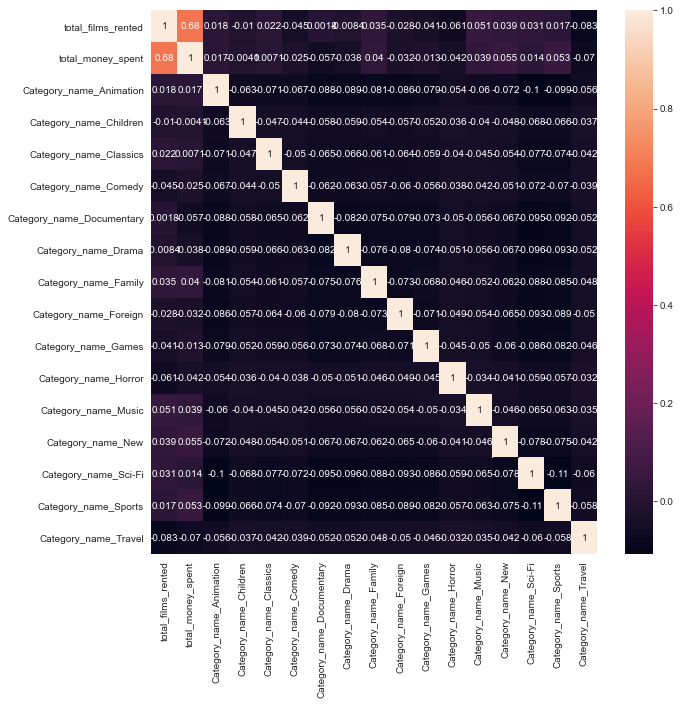

In [25]:
# Numerical columns

# Correlation
corr_matrix=categorical.corr(method='kendall')
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

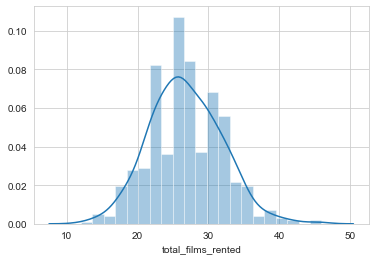

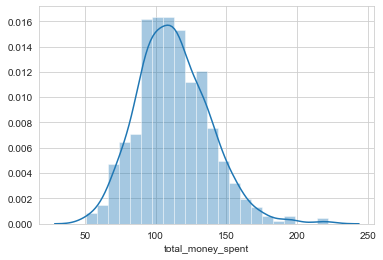

In [26]:
# Distribution

sns.distplot(concat['total_films_rented'])
plt.show()

sns.distplot(concat['total_money_spent'])
plt.show()

In [27]:
y=concat['Rented this month']
x1= concat.drop(['city','Category_name','Rented this month','Rented last month'], axis=1)

In [28]:
X = x1.copy()

In [29]:
from sklearn.preprocessing import StandardScaler

transformer = StandardScaler().fit(X)
x_standarized = transformer.transform(X)
x_standarized = pd.DataFrame(x_standarized)

In [30]:
x = pd.concat([X,categorical], axis = 1)

In [31]:
x.head()

,total_films_rented,total_money_spent,total_films_rented,total_money_spent,Category_name_Animation,Category_name_Children,Category_name_Classics,Category_name_Comedy,Category_name_Documentary,Category_name_Drama,Category_name_Family,Category_name_Foreign,Category_name_Games,Category_name_Horror,Category_name_Music,Category_name_New,Category_name_Sci-Fi,Category_name_Sports,Category_name_Travel
0,32,118.68,32,118.68,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,27,128.73,27,128.73,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,26,135.74,26,135.74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,22,81.78,22,81.78,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,38,144.62,38,144.62,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
print(x.isna().sum())

total_films_rented           0
total_money_spent            0
total_films_rented           0
total_money_spent            0
Category_name_Animation      0
Category_name_Children       0
Category_name_Classics       0
Category_name_Comedy         0
Category_name_Documentary    0
Category_name_Drama          0
Category_name_Family         0
Category_name_Foreign        0
Category_name_Games          0
Category_name_Horror         0
Category_name_Music          0
Category_name_New            0
Category_name_Sci-Fi         0
Category_name_Sports         0
Category_name_Travel         0
dtype: int64


In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=250)

In [ ]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr').fit(X_train, y_train)

# problem with Nan Values, i will fix this today

In [ ]:
from sklearn.metrics import accuracy_score

predictions = classification.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, predictions))
confusion_matrix(y_test, predictions)
plot_confusion_matrix(classification, X_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

from sklearn.metrics import cohen_kappa_score
print('Cohen Kappa score',cohen_kappa_score(y_test, predictions))